# Visualize mesh
Given the vertices and faces indeces (texture map is optional), visualize a 3D mesh using Pytorch3D. This notebbook reads **.ply** , **.mrc** and **.obj** files and visualizes the 3D mesh. The contents of this notebook are:


*   Install Pytorch3D
*   Define Renderer
*   Read mesh/volume files
*   Visualize mesh
    *   Visualize mesh render
    *   Visualize 360&deg; video




## Install Pytorch3D

In [ ]:
# Install Pytorch3D
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.10.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

device = 'cuda'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  404k    0  404k    0     0  1372k      0 --:--:-- --:--:-- --:--:-- 1372k
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-qq5udyj6
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-qq5udyj6
  Running command git checkout -q 2bd65027ca5c3b87b77d4f05b8eacae58d8d106f
     |████████████████████████████████| 50 kB 3.3 MB/s 
     |████████████████████████████████| 596 kB 10.3 MB/s 
  Created wheel for pytorch3d: filename=pytorch3d-0.6.2-cp37-cp37m-linux_x86_64.whl size=30640173 sha256=18c1488f1c57aa9cc4c3da80951119e7f876a5f8432a53cff765bce9e724fc4c
  Sto

In [ ]:
# Import Pytorch3D Libs
%cd /content
import torch
import numpy as np
from pytorch3d.io import load_objs_as_meshes, load_obj, load_ply
from pytorch3d.structures import Meshes

from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLOrthographicCameras, 
    FoVPerspectiveCameras,
    PerspectiveCameras,
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    HardPhongShader,
    TexturesAtlas,
    TexturesVertex,
    SoftPhongShader,
    SoftSilhouetteShader,
    BlendParams,
    TexturesVertex,
    TexturesUV, Textures
)

from pytorch3d.transforms import matrix_to_quaternion, quaternion_to_axis_angle, matrix_to_rotation_6d, axis_angle_to_matrix

/content


In [ ]:
!pip install matplotlib
!pip install imageio
!pip install scipy
!pip install Ninja
!pip install imageio_ffmpeg
!pip install install -U scikit-image # for marching cubes
!pip install mrcfile # to save shape as .mrc volume shape
!pip install plyfile
!pip install trimesh
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 108 kB 5.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.9 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.5 MB 4.4 MB/s 
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3
ERROR: pip's dependency resolver does not currently ta

## Define Renderer

In [ ]:
# Define camera matrix C
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras,
    FoVPerspectiveCameras
)
device = torch.device("cuda:0")

In [ ]:
# define Phong renderer

from pytorch3d.renderer import  (MeshRenderer, MeshRasterizer, SoftPhongShader,
    PointLights, Materials, RasterizationSettings,BlendParams
)

def get_phong_renderer(C_init, 
                      sigma=1.0e-4, 
                      gamma=1.0e-7, 
                      faces_per_pixel=50,
                      img_size=256,
                       blur_radius=1, background_path="", device=device):
  lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

  materials = Materials(
    device=device,
    specular_color=[[0.0, 0.0, 0.0]],
    shininess=0.0)
  
  try:
    background_color = Image.open(background_path)/ 255
    #background_color = [H, W, 3] # from (0-1)
  except:
    background_color = (1,1,1)
  
  blend_params = BlendParams(background_color=background_color, sigma=sigma, gamma=gamma)

  
  #blend_params = BlendParams(sigma=1e-4, gamma=1e-4, background_color=background/255)
  if blur_radius is not 0:
      blur_radius= np.log(1. / 1e-4 - 1.) * blend_params.sigma
  else: blur_radius = 0

  raster_settings = RasterizationSettings(
      image_size=img_size,
      blur_radius= blur_radius, 
      faces_per_pixel=faces_per_pixel, 
  )

  r = MeshRenderer(
      rasterizer=MeshRasterizer(
          cameras=C_init,
          raster_settings=raster_settings
      ),
      
      shader=HardPhongShader(device=device, cameras=C_init, lights=lights) )
  '''
      shader = SoftPhongShader(
          device=device, 
          blend_params = blend_params,
          cameras=C_init,
          materials=materials,
          lights=lights,  
      ) 
  '''
  

  return r

## Read Mesh/Volume files

In [122]:
from skimage import measure
import mrcfile
input_file = '/content/drive/MyDrive/datasets/eg3d/shapes/seed0000.ply' # @param
camera_file = '/content/drive/MyDrive/datasets/eg3d/cam_poses/seed0000.npy' # @param
#camera_file = input_file.replace('shapes', 'cam_poses').replace(format, 'npy') 

# find format file
format = input_file.split('.')[-1]

if format not in ['obj', 'ply', 'mrc']  :
  print("********* Wrong input file ************")


if 'obj' in format:
  print("Read .obj file")
  verts, faces, aux = load_obj(input_file)
  verts_rgb = 0.5* torch.ones_like(verts)[None] # (1, V, 3)
  textures = Textures(verts_rgb=verts_rgb.to(device))
  mesh =  Meshes(verts=[verts], faces=[faces.verts_idx], textures=textures)
if 'ply' in format:
  print("Read .ply file")
  verts, faces = load_ply(input_file)
  verts_rgb = torch.from_numpy(np.random.randint(0,255, size=verts.shape) / 255).unsqueeze(0).to(torch.float32)
  verts_rgb = 0.5* torch.ones_like(verts)[None] # (1, V, 3)
  textures = Textures(verts_rgb=verts_rgb.to(device))
  mesh =  Meshes(verts=[verts], faces=[faces], textures=textures)
if 'mrc' in format:
  print("Read .mrc file")
  with mrcfile.open(input_file) as mrc:
    volume = mrc.data
    sigmas = volume[0:, 0:512, 0:512]
    # Use marching cubes to obtain the surface mesh of these ellipsoids
    verts, faces, normals, values = measure.marching_cubes(sigmas, level=1)
    mesh = Meshes(verts=verts, faces=faces)


Read .ply file
torch.Size([868802, 3]) torch.float32 torch.int64 torch.Size([1737564, 3])


## Visualize mesh
So to get the expected rendering outcome, users need to make sure that their 3D input data and cameras abide by these PyTorch3D coordinate system assumptions. The PyTorch3D coordinate system assumes +X:left, +Y: up and +Z: from us to scene (right-handed).

[[ 1.0000000e+00 -6.4913070e-09  4.6791190e-08]
 [ 0.0000000e+00 -9.9051380e-01 -1.3741325e-01]
 [ 4.7239311e-08  1.3741325e-01 -9.9051380e-01]] [[-2.2863321e-10]
 [ 6.7143480e-04]
 [ 5.2305181e-03]]
torch.float32 torch.float32 torch.float32


/usr/local/lib/python3.7/dist-packages/pytorch3d/transforms/transform3d.py:800: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)


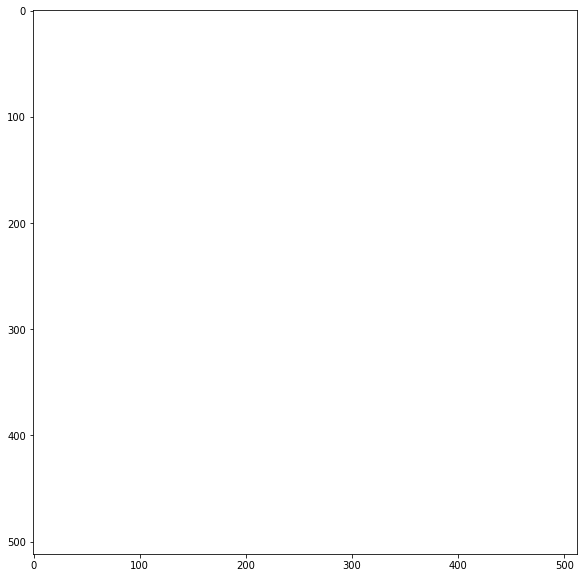

In [104]:
from pytorch3d.renderer.cameras import get_ndc_to_screen_transform
from pytorch3d.renderer.cameras import OrthographicCameras
from pytorch3d.utils import cameras_from_opencv_projection
cam = np.load(camera_file)
extrinsics= cam[0, 0:16] # first 16  ( R | t ) (4 x 4)
intrinsics = cam[0, 16:25]#K = | f,  s , px | 0  = (intrinsics | 0)
                         #     | 0 , f , py | 0
                         #     | 0 , 0 , 1  | 0  # intrinsic is in normalized space
a = intrinsics.reshape(3,3)
b = np.zeros((3,1))
K = np.hstack((a,b)) # K - intrinsics homogenous
K[0,0] =  K[0,0] 
K[0,2] = - K[0,2] 
K[0, 3] = K[0,3] 
K[1,2] = K[1,2] 
R_n_T= extrinsics.reshape(4, 4)
image_size = torch.from_numpy(np.array([[512, 512]]))
R = R_n_T[0:3, :3] # R matrix 
T = R_n_T[0:3, 3:] / 512 # T matrix
print(R, T)
P = K @ R_n_T
P = torch.from_numpy(P).unsqueeze(0).to('cuda').to(torch.float32)
R = torch.from_numpy(R).unsqueeze(0).to('cuda').to(torch.float32)
T = torch.from_numpy(T.transpose()).to('cuda').to(torch.float32)
f = K[0,0] 
p = ((K[0,2] , K[1,2] ),)
print(R.dtype, T.dtype, P.dtype)
#C = OrthographicCameras(R=R, T=T, device=device)
#C = PerspectiveCameras(R=R,T=T, focal_length=-f, principal_point=p, in_ndc=False, image_size=image_size, device=device)
C = cameras_from_opencv_projection(R=R, tvec=T, camera_matrix=P, image_size=image_size)
renderer = get_phong_renderer(C, faces_per_pixel=1, blur_radius=0, sigma = 0, img_size=512) # set render size
render = renderer(mesh.to(device)).detach().cpu().numpy()[0,:,:,0:3]
plt.figure(figsize=(10, 10))
plt.imshow(render)

# update K
K[0,0] = f 
K[0,2] = list(p[0])[0]
K[1,2] = list(p[0])[1]

/usr/local/lib/python3.7/dist-packages/pytorch3d/transforms/transform3d.py:800: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)


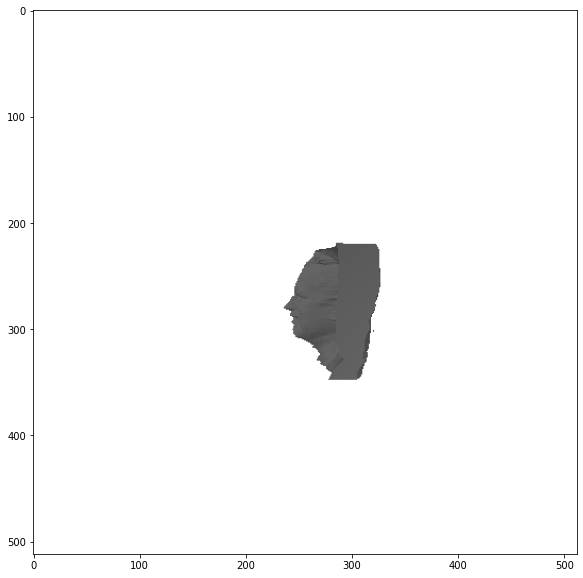

In [88]:
# @title Visualize render
distance = 1250 # distance from camera to the object
elevation = 0 # angle of elevation in degrees
azimuth = 85 # No rotation so the camera is positioned on the +Z axis. 
# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device)
T = torch.from_numpy(np.array([[-320.0,  -340,  distance]]))
#C = FoVPerspectiveCameras(device=device, R=R , T=T)
C = PerspectiveCameras(R=R,T=T, device=device) # for square images
renderer = get_phong_renderer(C, faces_per_pixel=50, blur_radius=0, sigma = 0.0000001, img_size=512)
render = renderer(mesh.to(device)).detach().cpu().numpy()[0,:,:,0:3]
plt.figure(figsize=(10, 10))
plt.imshow(render)

In [ ]:
# Render video.
import imageio
output_video = '/content/out2.mp4'
video_out = imageio.get_writer(output_video, mode='I', fps=30, codec='libx264')

for angle in np.arange(0,720 , 5):
  R, T = look_at_view_transform(dist=-1, elev=0, azim=angle) # 0 elevation , and 0 azimuth
  C = FoVPerspectiveCameras(device=device, R=R, T=T)
  renderer = get_phong_renderer(C, faces_per_pixel=1, blur_radius=0, img_size=520)
  render = renderer(mesh.to(device)).detach().cpu().numpy()[0,:,:,0:3]
  render = np.array((render * 127.5 + 128), dtype=np.uint8) # convert to uint8
  video_out.append_data(render)

video_out.close()


# Display video
from IPython.display import HTML
from base64 import b64encode
mp4 = open(output_video,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)


In [ ]:
# Render video.
import imageio
output_video = '/content/out3.mp4'
video_out = imageio.get_writer(output_video, mode='I', fps=30, codec='libx264')

for angle in np.arange(0,720 , 5):
  R, T = look_at_view_transform(dist=1000, elev=5, azim=angle) # 0 elevation , and 0 azimuth
  C = FoVPerspectiveCameras(device=device, R=R, T=T)
  renderer = get_phong_renderer(C, faces_per_pixel=1, blur_radius=0, img_size=520)
  render = renderer(mesh.to(device)).detach().cpu().numpy()[0,:,:,0:3]
  render = np.array((render * 127.5 + 128), dtype=np.uint8) # convert to uint8
  video_out.append_data(render)

video_out.close()


# Display video
from IPython.display import HTML
from base64 import b64encode
mp4 = open(output_video,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)


## Visualize Mesh from Depth Map
Select the depth map to be converted to a mesh. The output is a mesh file (.obj)

In [156]:
# Function borrowed from https://github.com/sfu-gruvi-3dv/deep_human
def depth2mesh(depth, mask, filename='mesh', save=True):
    h = depth.shape[0]
    w = depth.shape[1]
    depth = depth.reshape(h,w,1)
    faces = []  # N x 3  number of triangles
    verts = [] # V x 3 number of vertices
    v_strings = [] # strings with vertices for obj
    f_strings = [] # strings with faces for obj
    for i in range(h):
        for j in range(w):
            verts.append( [float(2.0*i/h) , float(2.0*j/w), float(depth[i,j,0])] )
            v_strings.append('v '+str(float(2.0*i/h))+' '+str(float(2.0*j/w))+' '+str(float(depth[i,j,0]))+'\n')

    threshold = 1.1 # adapted for better mesh quality --> the higher the more robust the result
    # no mesh face gaps
   

    for i in range(h-1):
        for j in range(w-1):
            if i < 2 or j < 2:
                continue
            localpatch= np.copy(depth[i-1:i+2,j-1:j+2])
            dy_d = localpatch[0, :] - localpatch[1, :]
            dx_l = localpatch[:, 0] - localpatch[:, 1]
            dx_r = localpatch[0 ,:] - localpatch[-1, :]
            dy_u = localpatch[:, 0] - localpatch[:, -1]

            dy_u = np.abs(dy_u)
            dx_l = np.abs(dx_l)
            dy_d = np.abs(dy_d)
            dx_r = np.abs(dx_r)
            if np.max(dy_u)<threshold and np.max(dx_l) < threshold and np.max(dy_d) < threshold and np.max(dx_r) < threshold and mask[i,j]:
                faces.append([int(j+i*w+1), int(j+i*w+1+1), int((i + 1)*w+j+1)])
                faces.append([int((i+1)*w+j+1+1), int((i+1)*w+j+1), int(i * w + j + 1 + 1)])
                # strings for .obj format
                f_strings.append('f '+str(int(j+i*w+1))+' '+str(int(j+i*w+1+1))+' '+str(int((i + 1)*w+j+1))+'\n')
                f_strings.append('f '+str(int((i+1)*w+j+1+1))+' '+str(int((i+1)*w+j+1))+' '+str(int(i * w + j + 1 + 1)) + '\n')
    
    f = open(filename + ".obj", "w")
    if save:
      for index, v in enumerate(v_strings):
        f.write(v)

      for index, fac in enumerate(f_strings):
        f.write(fac)
    f.close()


    verts = torch.from_numpy(np.array(verts)) 
    faces = torch.from_numpy(np.array(faces))

    # convert to mesh
    verts_rgb = 0.5* torch.ones_like(verts)[None] # (1, V, 3)
    textures = Textures(verts_rgb=verts_rgb.to(device))
    mesh =  Meshes(verts=[verts], faces=[faces], textures=textures)

    return mesh

In [157]:
import PIL
filename = '/content/mesh'
depth_path = '/content/drive/MyDrive/datasets/eg3d/depth128x128/seed0001.png' # @param
img = np.array(PIL.Image.open(depth_path))
depth = -((img/127.5) - 127.5) # to account for the - in the output
mask = img.copy()
mask[mask < 0] = 1
mesh = depth2mesh(depth=depth, mask=mask, filename=filename)
print("Results saved under ", filename)

Results saved under  /content/mesh
